# Kevin's Hokey Idea

If we want the Sinkhorn conditions to hold, then maybe we can compute
$$\min_{u, v} ||u \odot  (K v)  - a||^2 + ||v \odot (K^\top u) - b||^2.$$
with the idea that they hold at the true optimum. This proves difficult because this function isn't convex.

In [60]:
import torch
from torch.autograd import Variable
from cvxopt import matrix, solvers
from scipy.optimize import linprog

In [2]:
from scipy.optimize import fmin

In [65]:
from numpy.linalg import inv

## Scipy solution without gradient

In [8]:
n = 10
m = 12
eps = 1

In [38]:
C = np.random.chisquare(1, size=(n,m))
a = np.random.chisquare(3, size=n)
a /= sum(a)
b = np.random.chisquare(3, size=m)
b /= sum(b)

In [30]:
K  = np.exp(-C / eps)

In [31]:
u =  np.ones(n)
v = np.ones(m)

In [63]:
a / (K @ v)

array([ 0.02018975,  0.00748149,  0.00323363,  0.00739919,  0.01381704,
        0.0277226 ,  0.00452706,  0.02292825,  0.01311431,  0.01491322])

In [71]:
K.T @ (u * (K @ b / a))

array([ 64.55327608,  58.04005168,  67.77373027,  64.74587882,
        60.40099904,  62.12218701,  41.89043636,  51.60651877,
        66.20870974,  42.80512541,  35.63123405,  58.82154633])

In [73]:
inv(K.T @ K) @ K.T @ (u * (K @ b / a))

array([-25.77159526, -74.70418042, -19.76513811,  14.07008396,
        63.82780408,  41.11591399,  11.71018601,  10.80009004,
       -32.86870556,  33.58022834, -17.88713735,  33.0406135 ])

In [32]:
K @ v

array([ 6.78370313,  8.04539961,  6.8001308 ,  8.59432114,  9.6509563 ,
        6.04649298,  8.58108725,  7.52588829,  5.75047756,  8.6821425 ])

In [39]:
def objective_f(x):
    u = x[:n]
    v = x[-m:]
    return np.linalg.norm(u * (K @ v) - a)**2 + np.linalg.norm(v * (K.T @ u) - b)**2

In [50]:
bests = [objective_f(fmin(objective_f, x0=np.random.rand(n+m))) for i in range(10)]

(<matplotlib.lines.Line2D at 0x11612e588>,)

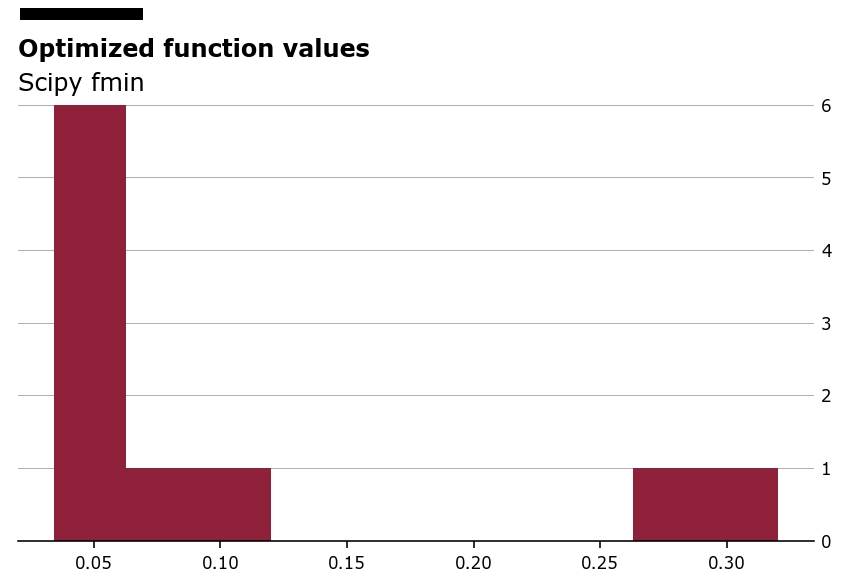

In [55]:
plt.hist(bests)
ft_ax(title='Optimized function values', subtitle='Scipy fmin', add_box=True)

## True  solution

In [61]:
def opt_lp(a, b, a_vec=None, b_vec=None, C=None):
    if C is None:
        if len(a_vec.shape) == 1:
            C =  np.sqrt((vecs_a[:,np.newaxis] - vecs_b)**2)
        else:
            distances_sq = (vecs_a[:,np.newaxis] - vecs_b)**2
            C = np.sqrt(distances_sq.sum(-1))
    c = C.flatten('F')
    A = np.vstack([np.kron(np.eye(n), np.ones(m)[np.newaxis,:]),
               np.kron(np.ones(n)[np.newaxis,:], np.eye(m))])
    
    c_mat = matrix(c)
    A_mat = matrix(A[:-1,:])
    b_mat = matrix(np.concatenate([a,b])[:-1])
    G_mat = matrix(-np.eye(n*m))
    h_mat = matrix(np.zeros(n*m))
    
    sol = solvers.lp(c_mat, G_mat, h_mat, A=A_mat, b=b_mat)
    return sol

In [62]:
opt_lp(a=a, b=b, C=C)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.0662e+00  1.0662e+00  4e+02  1e+01  2e+00  1e+00
 1: -1.2647e+00 -1.3315e+00  2e+01  8e-01  2e-01  8e-03
 2: -1.3533e-01 -1.3675e-01  2e+00  1e-01  2e-02  9e-03
 3:  7.0627e-02  7.0418e-02  4e-01  3e-02  6e-03  3e-03
 4:  1.0692e-01  1.0687e-01  8e-02  7e-03  2e-03  6e-04
 5:  1.1733e-01  1.1732e-01  3e-02  3e-03  5e-04  2e-04
 6:  1.1881e-01  1.1880e-01  1e-02  1e-03  2e-04  1e-04
 7:  1.2068e-01  1.2068e-01  5e-04  5e-05  1e-05  4e-06
 8:  1.2078e-01  1.2078e-01  7e-06  7e-07  1e-07  6e-08
 9:  1.2079e-01  1.2079e-01  7e-08  7e-09  1e-09  6e-10
Optimal solution found.


{'dual infeasibility': 1.495592053159577e-09,
 'dual objective': 0.12078626645123955,
 'dual slack': 3.7041350206675196e-09,
 'gap': 6.953637687749926e-08,
 'iterations': 9,
 'primal infeasibility': 6.952655755629579e-09,
 'primal objective': 0.12078626646224666,
 'primal slack': 1.390736241435259e-10,
 'relative gap': 5.756977090236541e-07,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 's': <120x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <120x1 matrix, tc='d'>,
 'y': <21x1 matrix, tc='d'>,
 'z': <120x1 matrix, tc='d'>}

## Torch solution with autograd

TODO